### Extreme gradient boosting classifier fitted by cross

 1. Load clean data into memory
 2. The 5 parameters found through random grid search and then error estimated through cross validation 
     
     - colsample_bytree: the subsample ratio of columns when constructing each tree
     - gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
     - learning_rate: Step size shrinkage used in update to prevents overfitting
     - max_depth: Maximum depth of a tree
     -  n_estimators: Size of sample of trees generated
     - subsample: Subsample ratio of the training instances
     
 3. Measure accuracy over test set and AUC

In [1]:
import numpy as np
import pandas as pd
import os

os.chdir('/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Fall2020/IML/TeamProject/TermProjectIML/bin')
from SplitData import *

from collections import OrderedDict

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix

import xgboost as xgb

from scipy.stats import uniform, randint


In [2]:
# Cross validation on grid of values XGB

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 400), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_trainval, y_trainval_bin)
xgb_params = search.best_params_

print(search.best_params_)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'colsample_bytree': 0.8854654189948783, 'gamma': 0.05056133806139512, 'learning_rate': 0.05523204183449923, 'max_depth': 2, 'n_estimators': 267, 'subsample': 0.6291052025456774}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


In [5]:
xgb_model = search.best_estimator_

y_pred_train = xgb_model.predict(X_trainval)

print("Accuracy on Train:", metrics.accuracy_score(y_trainval_bin, y_pred_train))

y_pred = xgb_model.predict(X_test)
# probabilities of class event
y_pred_proba = xgb_model.predict_proba(X_test)[:,0]

print('5-Fold CV Accuracy: ', search.best_score_)

print("Accuracy on Test:",metrics.accuracy_score(y_test_bin, y_pred))


Accuracy on Train: 0.9951456310679612
5-Fold CV Accuracy:  0.8933797909407666
Accuracy on Test: 0.8846153846153846


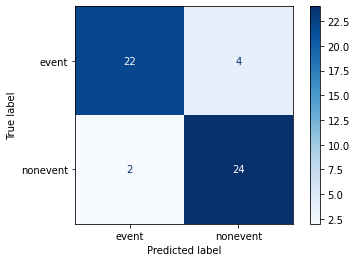

In [7]:
plot_confusion_matrix(xgb_model, X_test, y_test_bin,
                                 cmap=plt.cm.Blues,
                                 # normalize='true'
                                 )


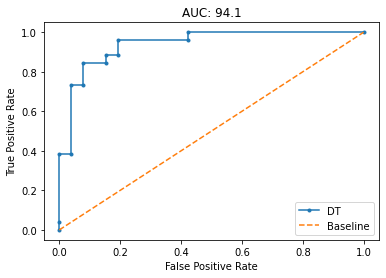

In [12]:
y_test_01 = pd.get_dummies(y_test_bin)['event']

fpr, tpr, thresholds = metrics.roc_curve(y_test_01, y_pred_proba)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr,tpr , marker='.', label='DT')
plt.title('AUC: '+ str(round(100*auc,1)) ) 
plt.plot(fpr, fpr, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [13]:
########################################################
# Multiclass

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 400), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_trainval, y_trainval)
xgb_params = search.best_params_

print(search.best_params_)



xgb_model = search.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  4.1min finished


{'colsample_bytree': 0.7816396748153905, 'gamma': 0.32384506027068116, 'learning_rate': 0.030156113098594745, 'max_depth': 2, 'n_estimators': 332, 'subsample': 0.7219125032632117}


In [14]:
y_pred_train = xgb_model.predict(X_trainval)

print("Accuracy on Train:",metrics.accuracy_score(y_trainval, y_pred_train))


y_pred = xgb_model.predict(X_test)

print('5-Fold CV Accuracy: ', search.best_score_)

print("Accuracy on Test:",metrics.accuracy_score(y_test, y_pred))


Accuracy on Train: 1.0
5-Fold CV Accuracy:  0.6699186991869919
Accuracy on Test: 0.6153846153846154


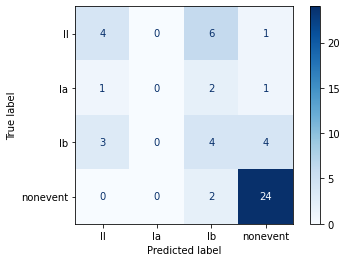

In [15]:
plot_confusion_matrix(xgb_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 # normalize='true'
                                 )


| Accuracy   | DT Binary  | RF Binary   | XGB Binary   | DT Multiclass | RF Multiclass | XGB Multiclass |
|------------|------------|-------------|-------------|---------------|---------------|----------------|
| Training   |        89% |        100% |        100% |        66%    |        100%   |        100%    |
| Validation |        83% |        86%  |        89%  |        61%    |        61%    |        67%     |
| Test       |        81% |        83%  |        88%  |        60%    |        67%    |        62%     |